# VES Experiments for 2D Bayesian Optimization

In [1]:
from ves import *
import matplotlib.pyplot as plt
import numpy as np
import torch

In [30]:
# Global parameters
BOUNDS = torch.zeros(2,2)
BOUNDS[:, 1] = torch.ones(2)
NUM_INIT = 2
NUM_TRIALS = 10
NUM_ITER = 100
NUM_PATHS = 64
# 2D discretization parameters
nx = 101
ny = 101

## Case 1: Rosenbrock function
Reference: https://en.wikipedia.org/wiki/Rosenbrock_function
$$f(x_1,x_2) = -(1-x_1)^2-100(x_2-x_1^2)^2$$

  0%|          | 0/10 [00:00<?, ?it/s]

Maximizer is  tensor([0.7500, 0.5000]) with value  -0.0


 20%|██        | 2/10 [21:50<1:27:45, 658.18s/it]/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/nokicheng/opt/anaconda3/

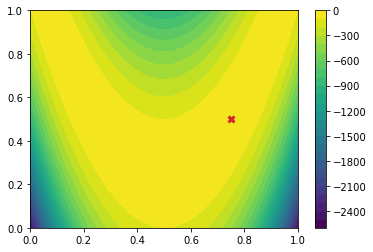

In [31]:
# Define and visualize the function
def f_rs(X):
    if isinstance(X, tuple):
        x,y = X
    elif X.ndim != 2:
        x,y = X[0],X[1]
    else:
        x,y = X[:,0],X[:,1]
    x = 4 * x - 2
    y = 4 * y - 1
    return -(1-x)**2-100*(y-x**2)**2

# plot function f_rs
X1,X2 = torch.linspace(BOUNDS[0,0], BOUNDS[0,1], nx),torch.linspace(BOUNDS[1,0], BOUNDS[1,1], ny)
Xx,Xy = torch.meshgrid(X1, X2)
X = torch.vstack((Xx.flatten(), Xy.flatten())).T
Y = f_rs(X)
max_id = torch.argmax(Y)
max_Y = torch.max(Y)
plt.plot(X[max_id, 0], X[max_id, 1], 'kx', mew=3, c='tab:red')
plt.contourf(Xx, Xy, f_rs((Xx,Xy)),25)
plt.colorbar()
print('Maximizer is ',X[max_id], 'with value ', max_Y.item())

ves_rs, ei_rs, mes_rs = run_2d_experiment(f_rs,
                                  bounds=BOUNDS,
                                  num_init=NUM_INIT,
                                  num_trials=NUM_TRIALS,
                                  num_iter=NUM_ITER,
                                  num_paths=NUM_PATHS,
                                  nx=nx,
                                  ny=ny)
ves_rs, ei_rs, mes_rs = np.log(max_Y - ves_rs), np.log(max_Y - ei_rs), np.log(max_Y - mes_rs)
ves_rs[ves_rs == -torch.inf], ei_rs[torch.isnan(ei_rs)], mes_rs[torch.isnan(mes_rs)] = -16.0, -16.0, -16.0
ves_rs_mean, ei_rs_mean, mes_rs_mean = ves_rs.mean(axis=0), ei_rs.mean(axis=0), mes_rs.mean(axis=0)
ves_rs_std, ei_rs_std, mes_rs_std = ves_rs.std(axis=0), ei_rs.std(axis=0), mes_rs.std(axis=0)

## Case 2: Three-Hump Camel Function
Source: https://www.sfu.ca/~ssurjano/camel3.html
$$f(x_1, x_2) = -2x_1^2+1.05x_1^4-\frac{x_1^6}{6}-x_1x_2-x_2^2,$$
where $x_1\in[-5,5], x_2\in[-5,5]$ get re-scaled.

  0%|          | 0/10 [00:00<?, ?it/s]

Maximizer is  tensor([0.5000, 0.5000]) with value  0.0


 90%|█████████ | 9/10 [1:33:44<10:46, 646.27s/it]/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/nokicheng/opt/anaconda3/

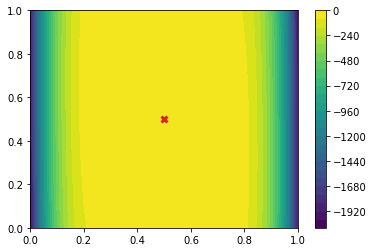

In [39]:
# Define and visualize the function
def f_thc(X):
    if isinstance(X, tuple):
        x,y = X
    elif X.ndim != 2:
        x,y = X[0],X[1]
    else:
        x,y = X[:,0],X[:,1]
    x = 10 * x - 5
    y = 10 * y - 5
    return -2*x**2+1.05*x**4-x**6/6-x*y-y**2

# plot function f_rs
X1,X2 = torch.linspace(BOUNDS[0,0], BOUNDS[0,1], nx),torch.linspace(BOUNDS[1,0], BOUNDS[1,1], ny)
Xx,Xy = torch.meshgrid(X1, X2)
X = torch.vstack((Xx.flatten(), Xy.flatten())).T
Y = f_thc(X)
max_id = torch.argmax(Y)
max_Y = torch.max(Y)
plt.plot(X[max_id, 0], X[max_id, 1], 'kx', mew=3, c='tab:red')
plt.contourf(Xx, Xy, f_thc((Xx,Xy)),25)
plt.colorbar()
print('Maximizer is ',X[max_id], 'with value ', max_Y.item())

ves_thc, ei_thc, mes_thc = run_2d_experiment(f_thc,
                                  bounds=BOUNDS,
                                  num_init=NUM_INIT,
                                  num_trials=NUM_TRIALS,
                                  num_iter=NUM_ITER,
                                  num_paths=NUM_PATHS,
                                  nx=nx,
                                  ny=ny)
ves_thc, ei_thc, mes_thc = np.log(max_Y - ves_thc), np.log(max_Y - ei_thc), np.log(max_Y - mes_thc)
ves_thc[ves_thc == -torch.inf], ei_thc[torch.isnan(ei_thc)], mes_thc[torch.isnan(mes_thc)] = -16.0, -16.0, -16.0
ves_thc_mean, ei_thc_mean, mes_thc_mean = ves_thc.mean(axis=0), ei_thc.mean(axis=0), mes_thc.mean(axis=0)
ves_thc_std, ei_thc_std, mes_thc_std = ves_thc.std(axis=0), ei_thc.std(axis=0), mes_thc.std(axis=0)

## Case 3: Himmelblau's Function
Reference: https://en.wikipedia.org/wiki/Himmelblau%27s_function
$$f(x_1, x_2) = -(x_1^2 + x_2 - 11)^2 - (x_1+x_2^2-7)^2,$$
where $x_1\in[-5,5], x_2\in[-5,5]$ get re-scaled.

  0%|          | 0/10 [00:00<?, ?it/s]

Maximizer is  tensor([0.8000, 0.7000]) with value  -0.0


 10%|█         | 1/10 [09:31<1:25:39, 571.03s/it]/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 90%|█████████ | 9/10 [1:25:35<09:32, 572.58s/it]/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
100%|██████████| 10/10 [1:35:08<00:00, 570.80s/it]
<ipython-input-33-1f9b46a1dda0>:33: RuntimeWarning: divide by zero encountered in log
  ves_hb, ei_hb, mes_hb = np.log(max_Y - ves_hb), np.log(max_Y - ei_hb), np.log(max_Y - mes_hb)


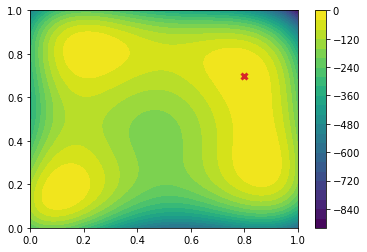

In [33]:
# Define and visualize the function
def f_hb(X):
    if isinstance(X, tuple):
        x,y = X
    elif X.ndim != 2:
        x,y = X[0],X[1]
    else:
        x,y = X[:,0],X[:,1]
    x = 10 * x - 5
    y = 10 * y - 5
    return -(x**2+y-11)**2-(x+y**2-7)**2

# plot function f_rs
X1,X2 = torch.linspace(BOUNDS[0,0], BOUNDS[0,1], nx),torch.linspace(BOUNDS[1,0], BOUNDS[1,1], ny)
Xx,Xy = torch.meshgrid(X1, X2)
X = torch.vstack((Xx.flatten(), Xy.flatten())).T
Y = f_hb(X)
max_id = torch.argmax(Y)
max_Y = torch.max(Y)
plt.plot(X[max_id, 0], X[max_id, 1], 'kx', mew=3, c='tab:red')
plt.contourf(Xx, Xy, f_hb((Xx,Xy)),25)
plt.colorbar()
print('Maximizer is ',X[max_id], 'with value ', max_Y.item())

ves_hb, ei_hb, mes_hb = run_2d_experiment(f_hb,
                                  bounds=BOUNDS,
                                  num_init=NUM_INIT,
                                  num_trials=NUM_TRIALS,
                                  num_iter=NUM_ITER,
                                  num_paths=NUM_PATHS,
                                  nx=nx,
                                  ny=ny)
ves_hb, ei_hb, mes_hb = np.log(max_Y - ves_hb), np.log(max_Y - ei_hb), np.log(max_Y - mes_hb)
ves_hb[ves_hb == -torch.inf], ei_hb[torch.isnan(ei_hb)], mes_hb[torch.isnan(mes_hb)] = -16.0, -16.0, -16.0
ves_hb_mean, ei_hb_mean, mes_hb_mean = ves_hb.mean(axis=0), ei_hb.mean(axis=0), mes_hb.mean(axis=0)
ves_hb_std, ei_hb_std, mes_hb_std = ves_hb.std(axis=0), ei_hb.std(axis=0), mes_hb.std(axis=0)

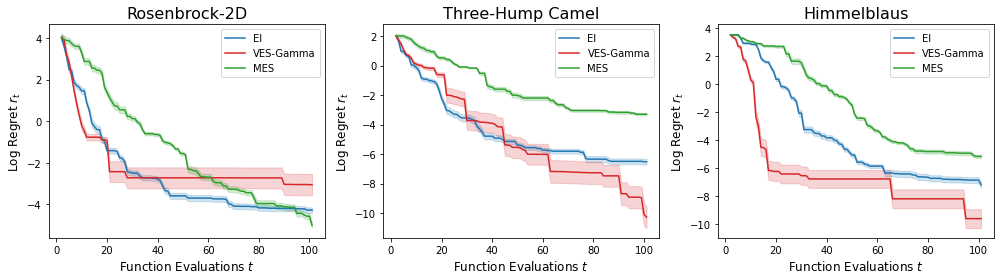

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))  # Create a 1x4 grid of subplots
names = ['Rosenbrock-2D', 'Three-Hump Camel','Himmelblaus']
std_cont = 0.1
data = [(ei_rs_mean, ei_rs_std, ves_rs_mean, ves_rs_std, mes_rs_mean, mes_rs_std),
        (ei_thc_mean, ei_thc_std, ves_thc_mean, ves_thc_std, mes_thc_mean, mes_thc_std),
        (ei_hb_mean, ei_hb_std, ves_hb_mean, ves_hb_std, mes_hb_mean, mes_hb_std)]
for l in range(3):
    ei_mean, ei_std, ves_mean, ves_std, mes_mean, mes_std = data[l]
    axs[l].plot(np.arange(len(ei_mean))+NUM_INIT, ei_mean, label='EI', c='tab:blue')
    axs[l].fill_between(np.arange(len(ei_mean))+NUM_INIT, ei_mean-std_cont*ei_std, ei_mean+std_cont*ei_std, color='tab:blue', alpha=0.2)
    axs[l].plot(np.arange(len(ves_mean))+NUM_INIT, ves_mean, label='VES-Gamma', c='tab:red')
    axs[l].fill_between(np.arange(len(ves_mean))+NUM_INIT, ves_mean-std_cont*ves_std, ves_mean+std_cont*ves_std, color='tab:red', alpha=0.2)
    axs[l].plot(np.arange(len(mes_mean))+NUM_INIT, mes_mean, label='MES', c='tab:green')
    axs[l].fill_between(np.arange(len(mes_mean))+NUM_INIT, mes_mean-std_cont*mes_std, mes_mean+std_cont*mes_std, color='tab:green', alpha=0.2)
    axs[l].legend()
    axs[l].set_xlabel(r'Function Evaluations $t$', fontsize=12)
    axs[l].set_ylabel(r'Log Regret $r_t$', fontsize=12)
    axs[l].set_title(names[l], fontsize=16)
plt.tight_layout()  # Adjust the layout
fig.savefig('ves_2d_5.pdf', dpi=300)